In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from pandas.api.types import is_string_dtype   
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score

warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('kidney_disease.csv')

In [3]:
pd.set_option('display.max_columns', None)
dataset

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,49.0,0.5,150.0,4.9,15.7,47,6700,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,31.0,1.2,141.0,3.5,16.5,54,7800,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,26.0,0.6,137.0,4.4,15.8,49,6600,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,50.0,1.0,135.0,4.9,14.2,51,7200,5.9,no,no,no,good,no,no,notckd


In [4]:
dataset.isnull().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

In [5]:
dataset[['htn','dm','cad','pe','ane']] = dataset[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
dataset[['rbc','pc']] = dataset[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
dataset[['pcc','ba']] = dataset[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
dataset[['appet']] = dataset[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})
dataset['classification'] = dataset['classification'].replace(to_replace={'ckd':0.0,'ckd\t':0.0,'notckd':1.0,'no':1.0})
dataset.rename(columns={'classification':'class'},inplace=True)


In [6]:
dataset['pe'] = dataset['pe'].replace(to_replace='good',value=0) # Not having pedal edema is good
dataset['appet'] = dataset['appet'].replace(to_replace='no',value=0)
dataset['cad'] = dataset['cad'].replace(to_replace='\tno',value=0)
dataset['dm'] = dataset['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})
dataset.drop('id',axis=1,inplace=True)

In [7]:
dataset['pcv'] = pd.to_numeric(dataset['pcv'], errors='coerce')
dataset['wc'] = pd.to_numeric(dataset['wc'], errors='coerce')
dataset['rc'] = pd.to_numeric(dataset['rc'], errors='coerce')

In [8]:
dataset

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,140.0,49.0,0.5,150.0,4.9,15.7,47.0,6700.0,4.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0
396,42.0,70.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,75.0,31.0,1.2,141.0,3.5,16.5,54.0,7800.0,6.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0
397,12.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,100.0,26.0,0.6,137.0,4.4,15.8,49.0,6600.0,5.4,0.0,0.0,0.0,1.0,0.0,0.0,1.0
398,17.0,60.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [9]:
col_list=dataset.columns.tolist()
for i in col_list:
    print(i+" ")
    print(dataset[i].median())

age 
55.0
bp 
80.0
sg 
1.02
al 
0.0
su 
0.0
rbc 
0.0
pc 
0.0
pcc 
0.0
ba 
0.0
bgr 
121.0
bu 
42.0
sc 
1.3
sod 
138.0
pot 
4.4
hemo 
12.649999999999999
pcv 
40.0
wc 
8000.0
rc 
4.8
htn 
0.0
dm 
0.0
cad 
0.0
appet 
1.0
pe 
0.0
ane 
0.0
class 
0.0


In [10]:
dataset = dataset.fillna(dataset.median())

In [11]:
dataset

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,0.0,0.0,0.0,0.0,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,0.0,0.0,0.0,0.0,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,140.0,49.0,0.5,150.0,4.9,15.7,47.0,6700.0,4.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0
396,42.0,70.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,75.0,31.0,1.2,141.0,3.5,16.5,54.0,7800.0,6.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0
397,12.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,100.0,26.0,0.6,137.0,4.4,15.8,49.0,6600.0,5.4,0.0,0.0,0.0,1.0,0.0,0.0,1.0
398,17.0,60.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.9,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [12]:
dataset.isnull().sum()

age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wc       0
rc       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64

In [13]:
category = ['sg','al','su','rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']
numerical = ['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']

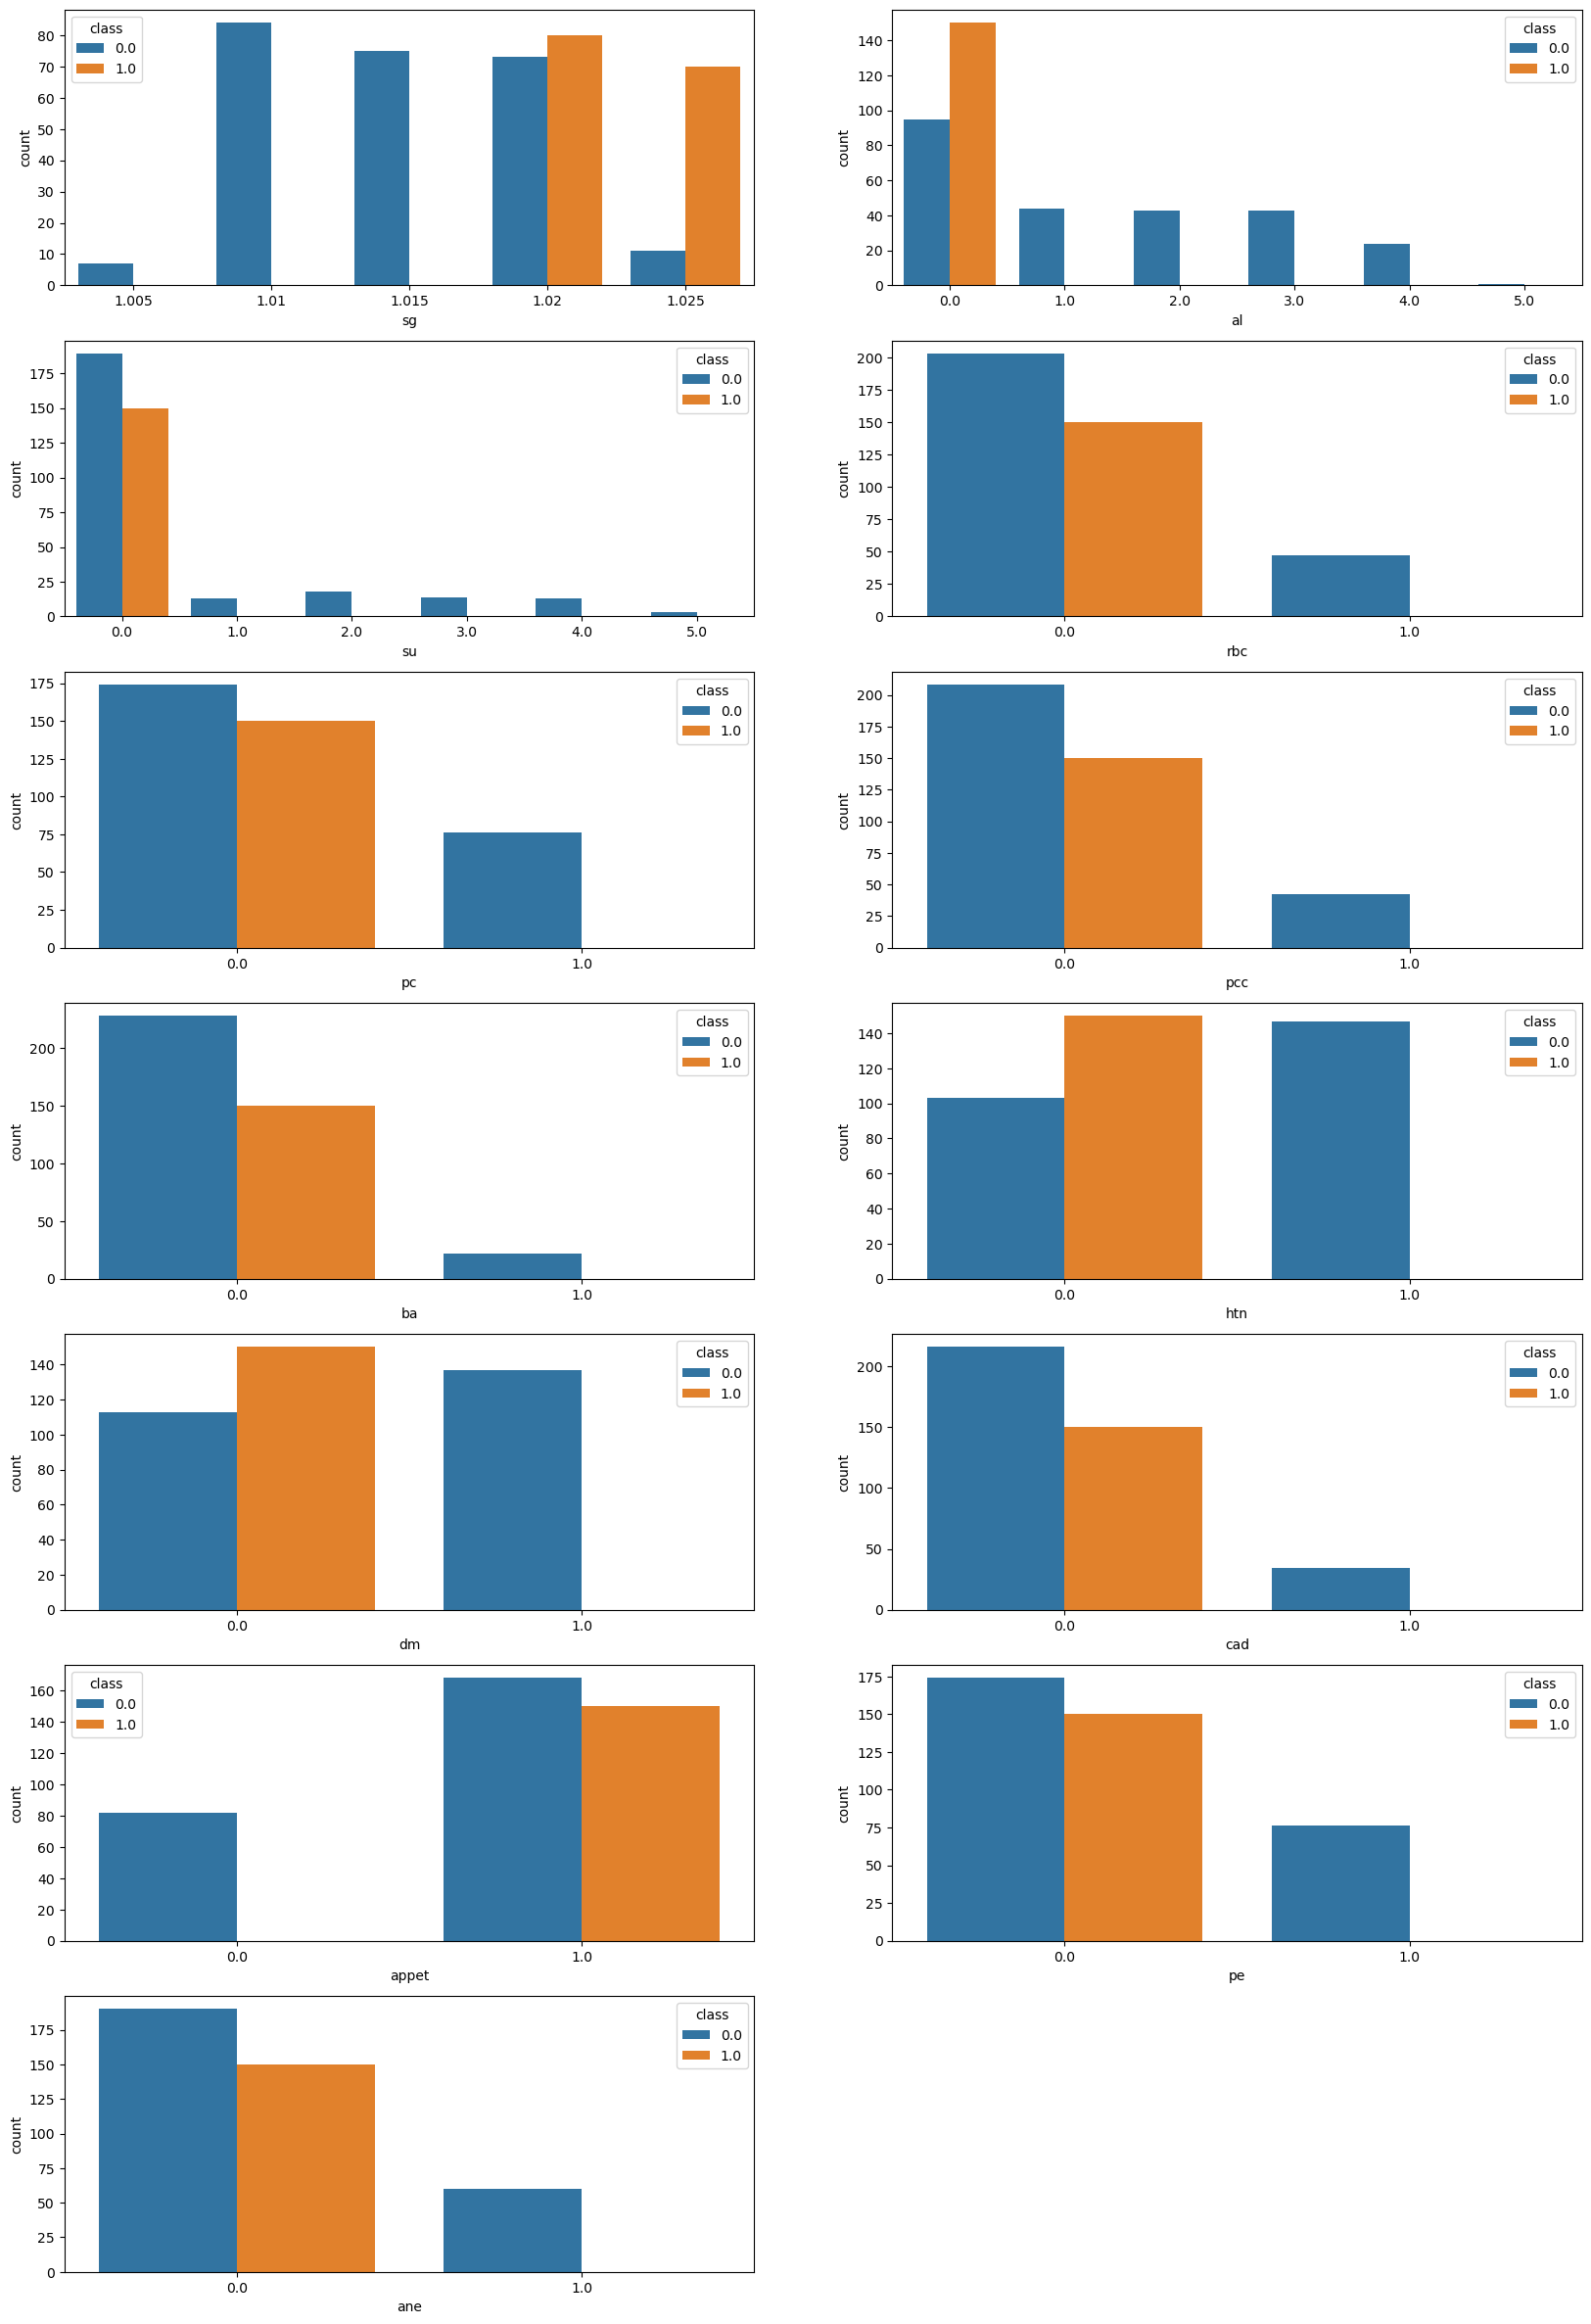

In [14]:
plt.figure(figsize = (20,30))
plot_number = 1
for column in category:
    if plot_number <= 14:
        ax = plt.subplot(7,2,plot_number)
        sns.countplot(x =column,hue='class',data = dataset)
    plot_number += 1
plt.show()

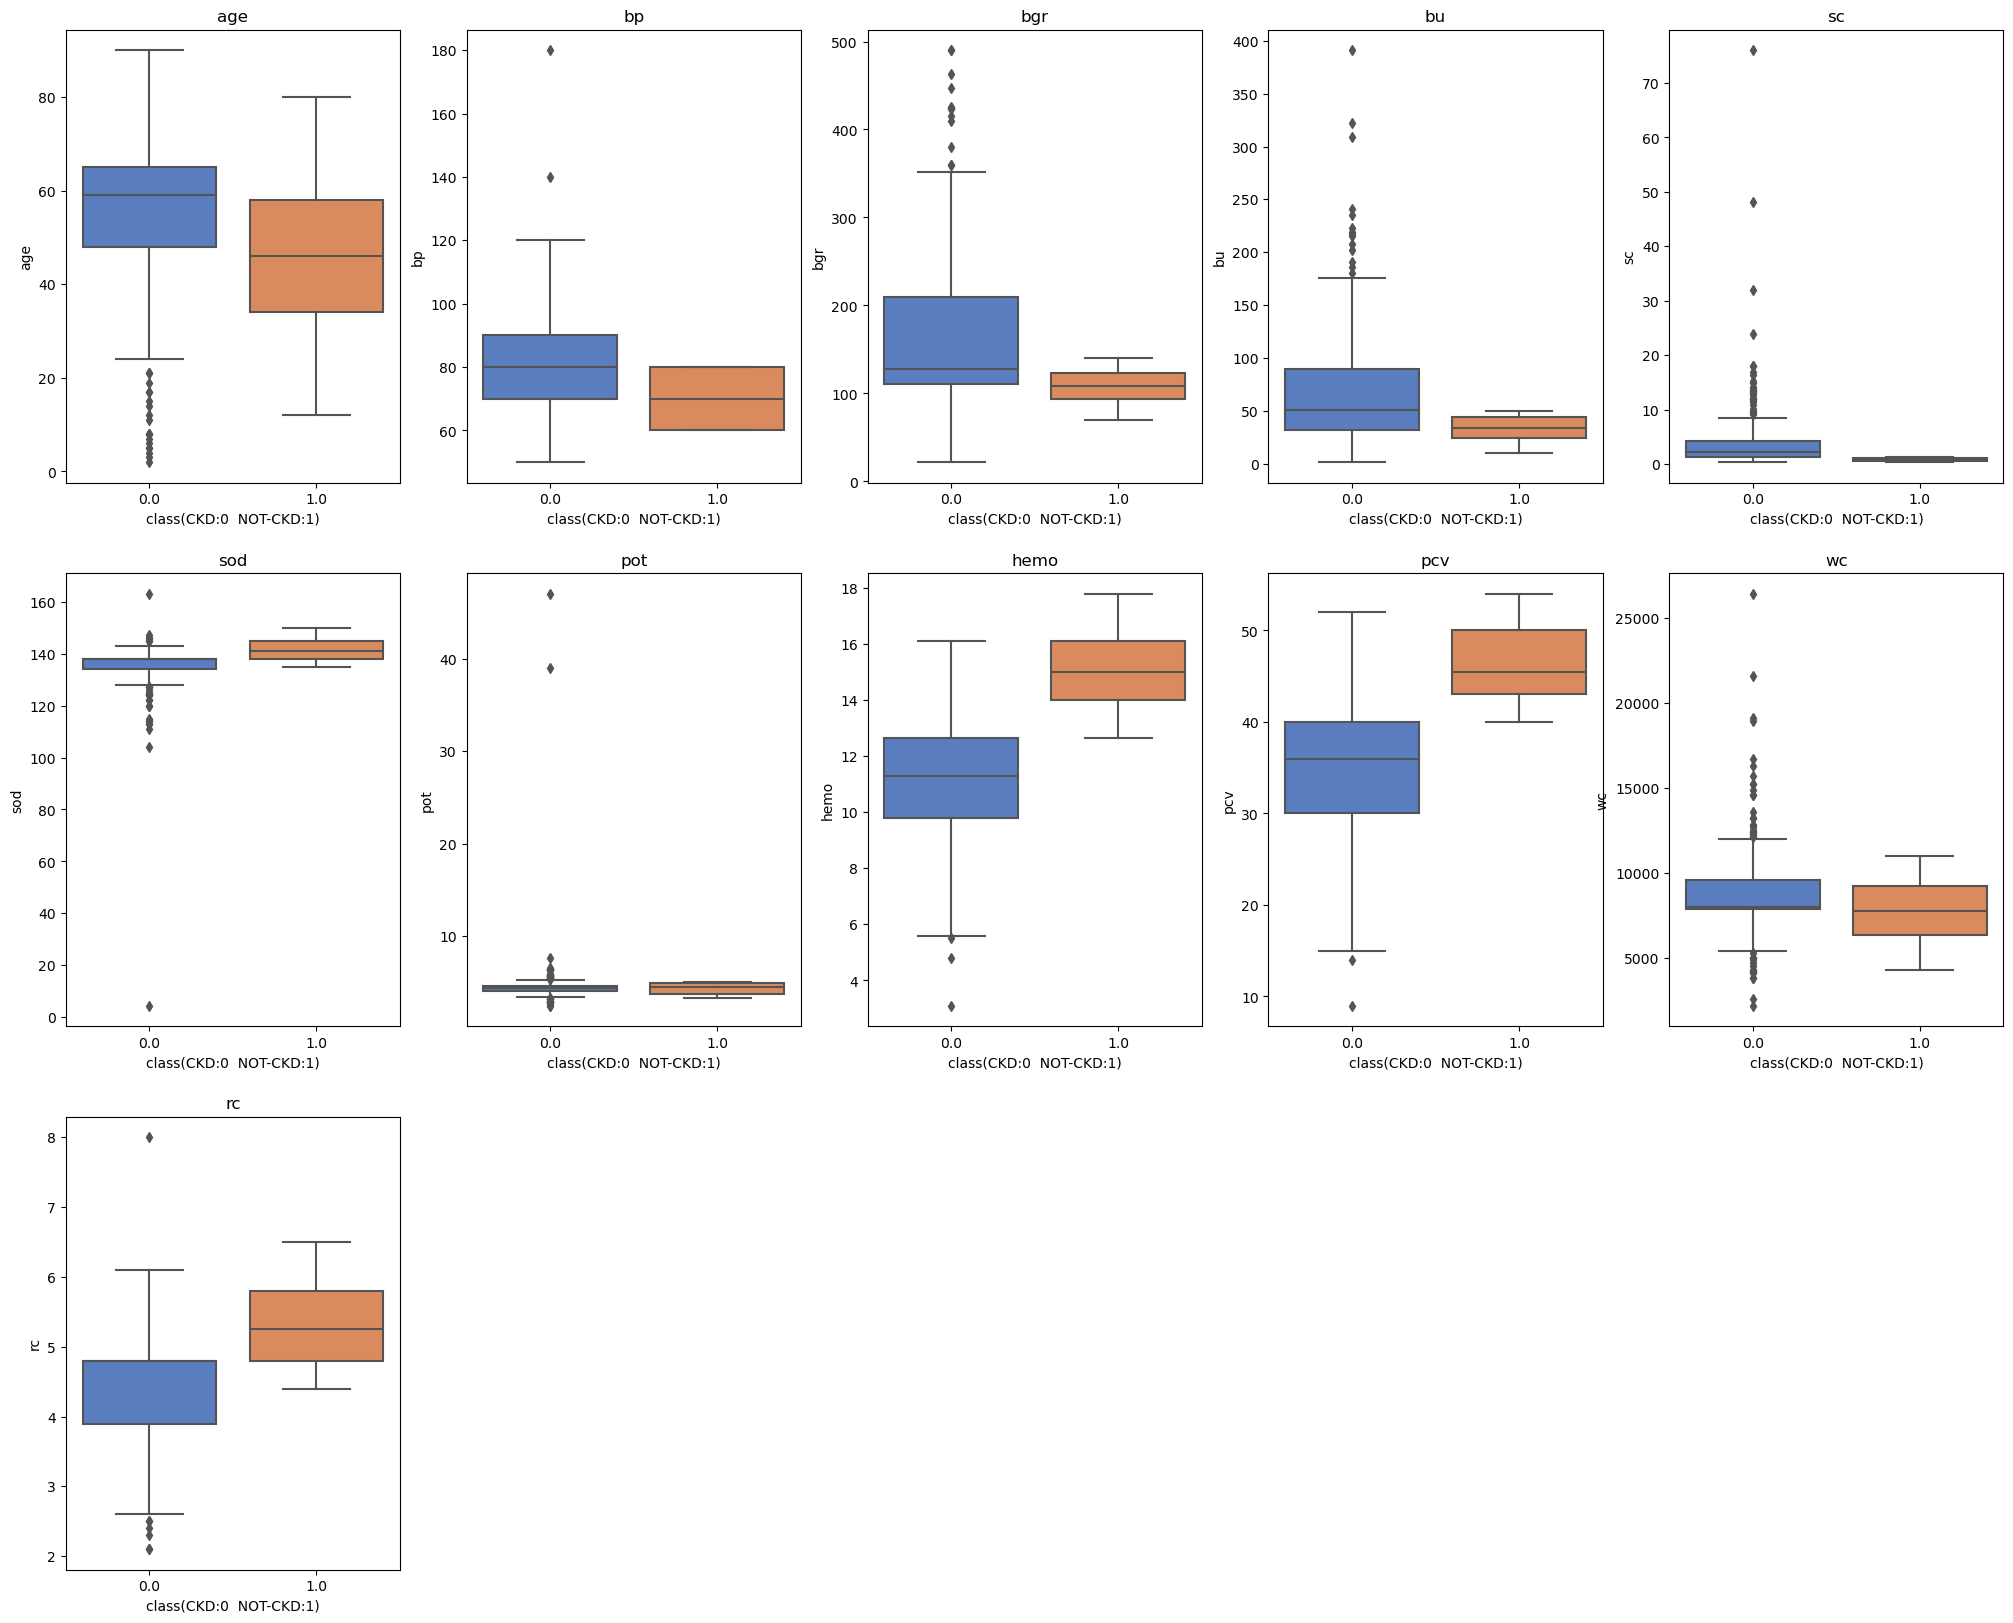

In [15]:
plt.figure(figsize = (25,20))
plot_number = 1
for column in numerical:
    if plot_number <= 14:
        ax = plt.subplot(3, 5, plot_number)
        sns.boxplot(data=dataset,
            x="class",
            y=column,
            palette = "muted"
           )
        ax.set_title(column)
        plt.xlabel("class(CKD:0  NOT-CKD:1)")
    plot_number += 1
plt.show()

In [16]:
co_mat = dataset.corr()

<Axes: >

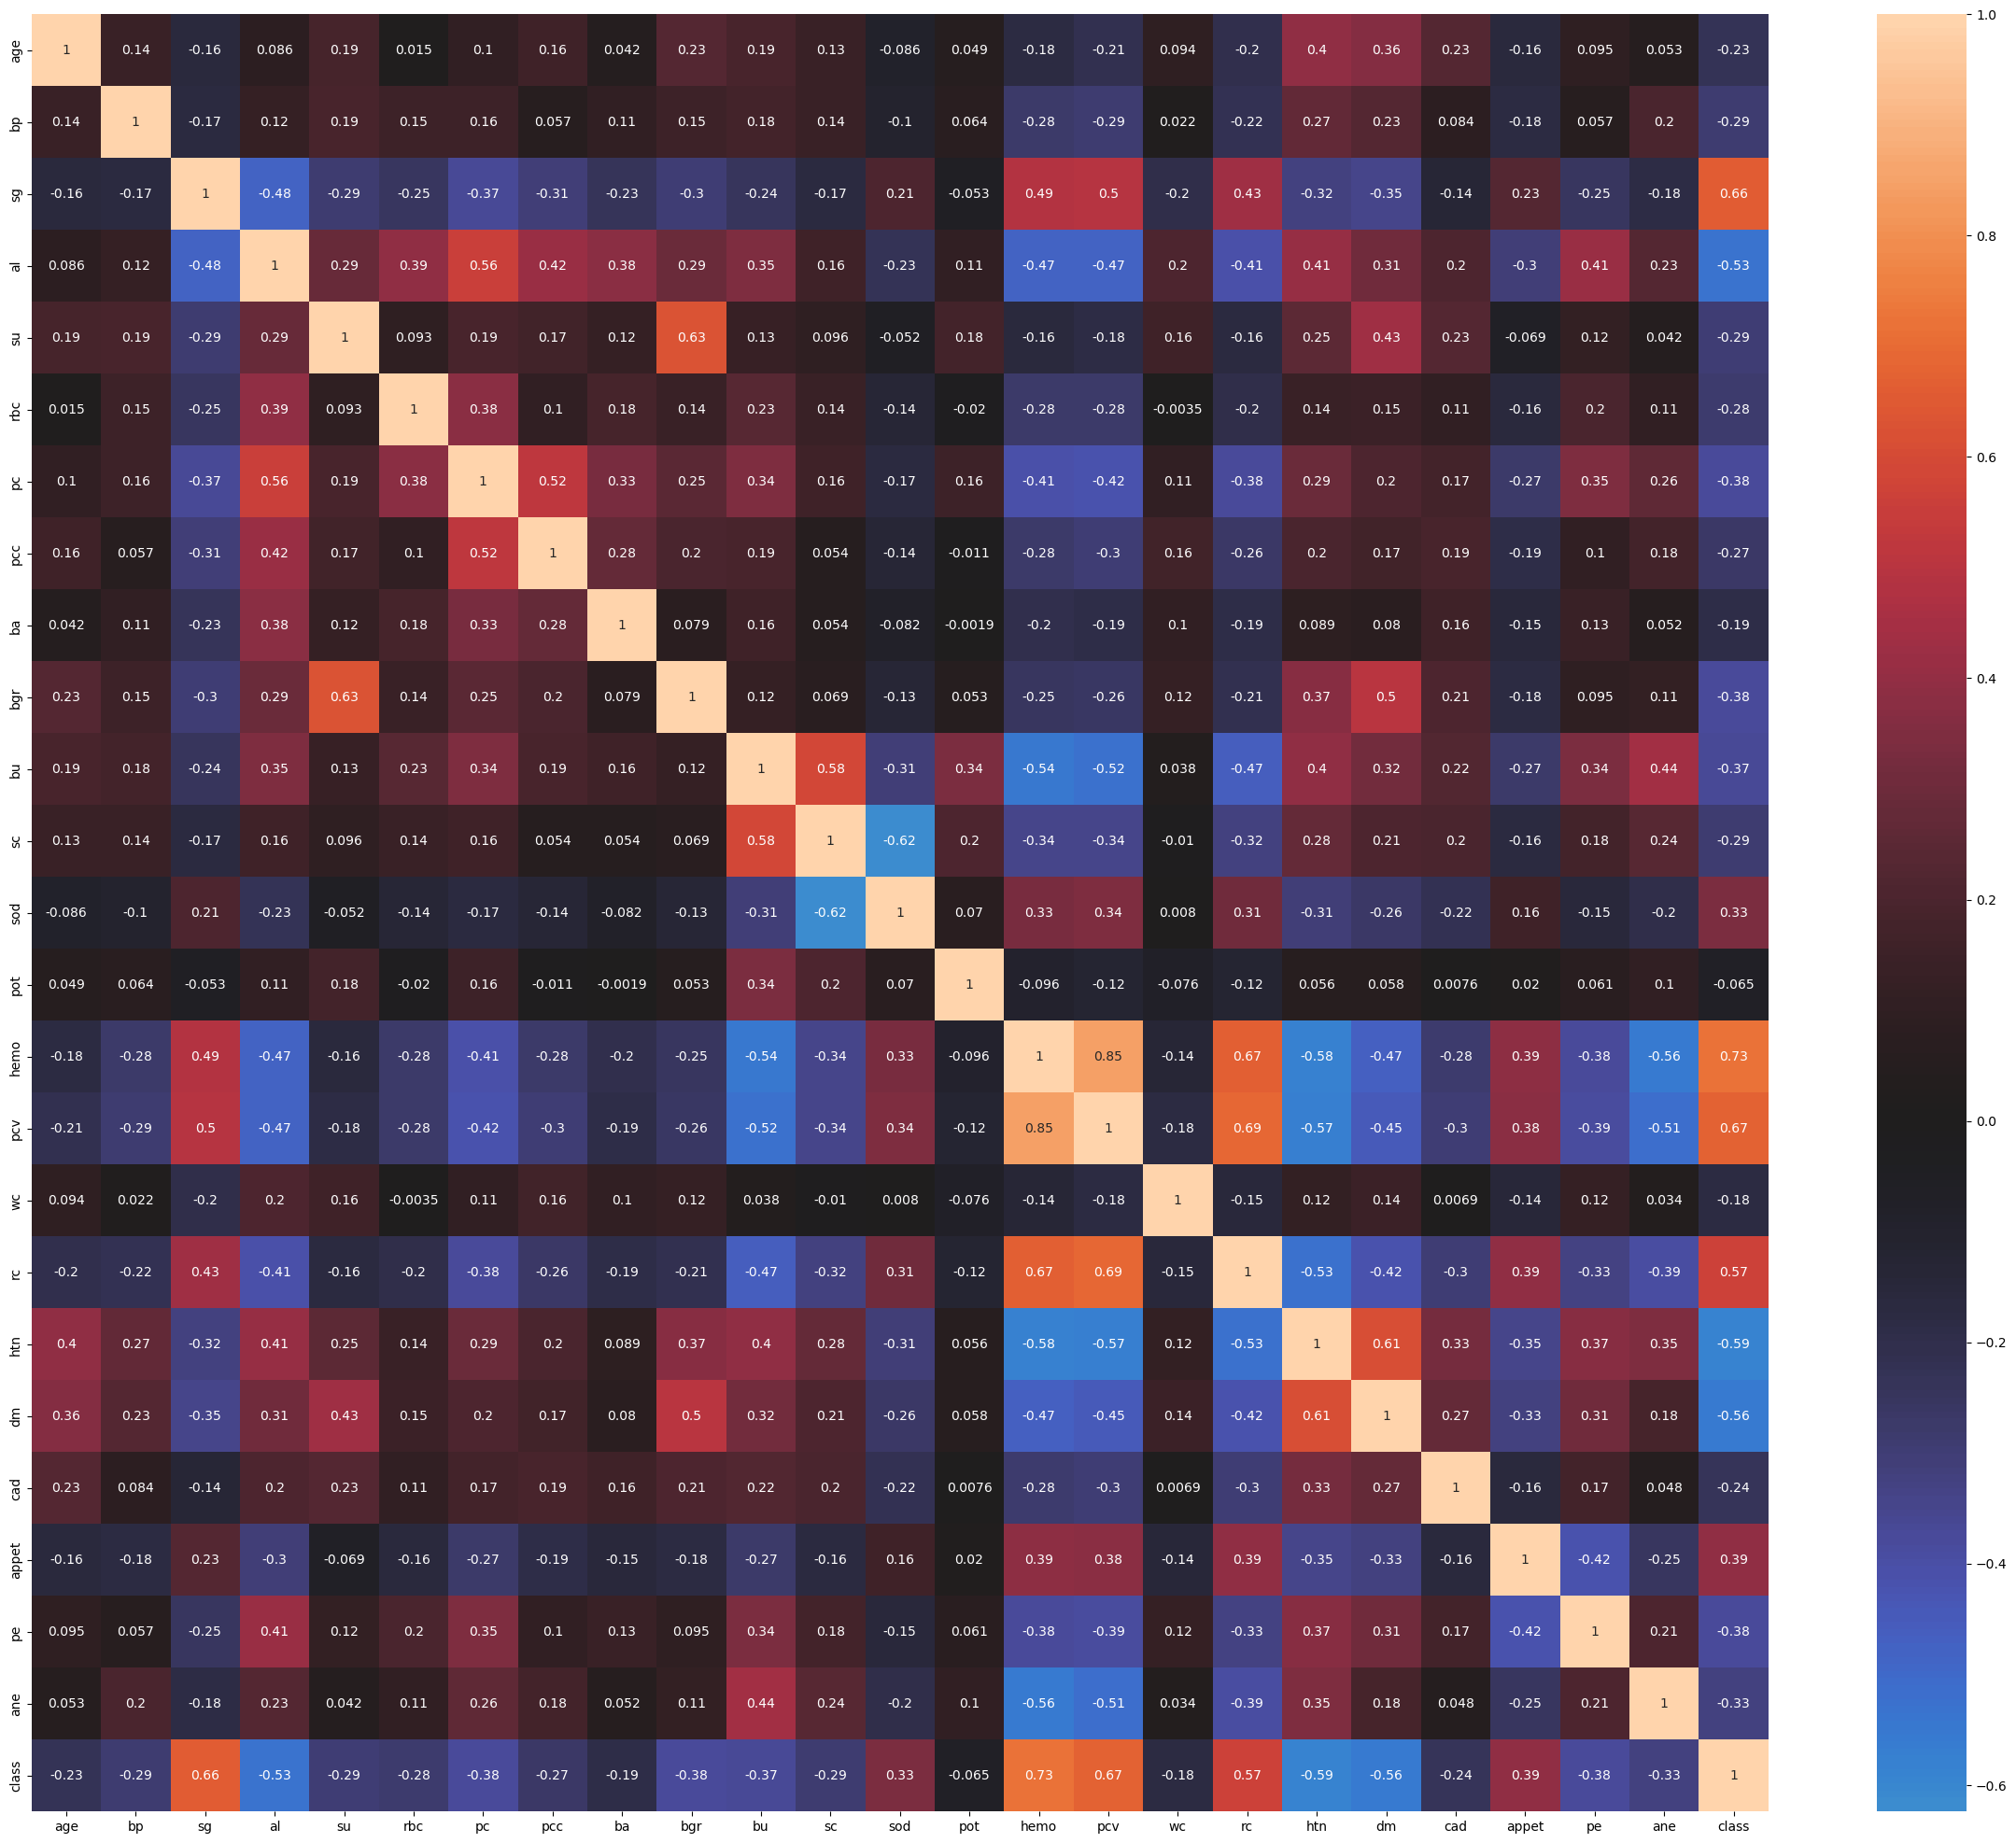

In [17]:
plt.figure(1, figsize=(30,25))
sns.heatmap(co_mat,center=0, annot=True, cbar=True)

In [18]:
X = dataset.drop('class', axis=1)
y = dataset['class']



Average accuracy score: 0.9774999999999998




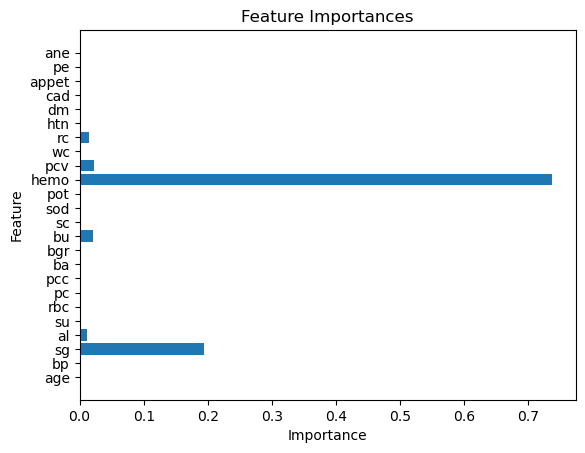

In [19]:
dt = DecisionTreeClassifier()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
print("\n")
print("Average accuracy score:", sum(scores)/len(scores))
print("\n")


importances = dt.feature_importances_
features = X.columns.tolist()
plt.barh(features, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()


Confusion matrix:
[[244   6]
 [  4 146]]
Precision: 96.05263157894737 %
F1 score: 96.68874172185431 %
Kappa: 94.68085106382979 %
Specificity: 97.6 %
Sensitivity: 97.33333333333334 %


Text(50.722222222222214, 0.5, 'True Class')

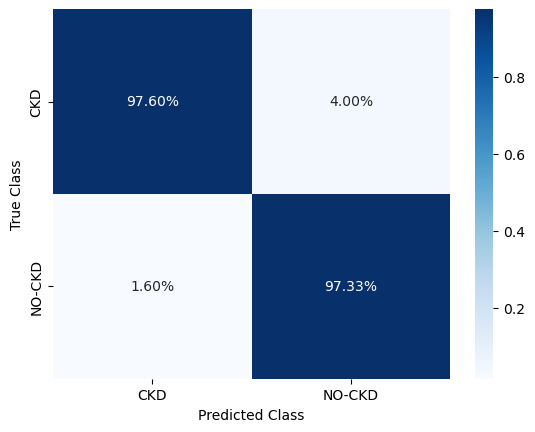

In [20]:
y_true = []
y_pred = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt.fit(X_train, y_train)
    y_true.extend(y_test)
    y_pred.extend(dt.predict(X_test))

cm = confusion_matrix(y_true, y_pred)

print("Confusion matrix:")
print(cm)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("Precision:", precision*100,"%")
print("F1 score:", f1*100,"%")
print("Kappa:", kappa*100,"%")
print("Specificity:", specificity*100,"%")
print("Sensitivity:", sensitivity*100,"%")


cm_normalized=cm/np.sum(cm,axis=1)
xl=['CKD', 'NO-CKD']
yl=['CKD','NO-CKD']
sns.heatmap(cm_normalized,cmap="Blues",fmt='.2%',annot=True,cbar_kws={"orientation":"vertical"},xticklabels=xl,yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")




Average accuracy score: 0.9775




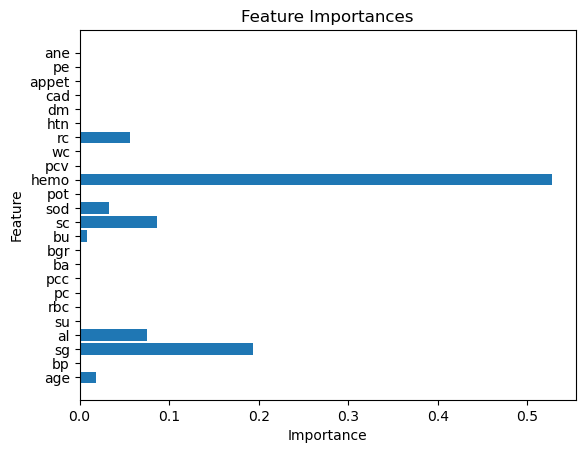

In [21]:
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    xg_cl.fit(X_train, y_train)
    y_pred = xg_cl.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
print("\n")
print("Average accuracy score:", sum(scores)/len(scores))
print("\n")



importances = xg_cl.feature_importances_
features = X.columns.tolist()
plt.barh(features, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()

Confusion matrix:
[[246   4]
 [  5 145]]
Precision: 97.31543624161074 %
F1 score: 96.98996655518394 %
Kappa: 95.19359145527369 %
Specificity: 98.4 %
Sensitivity: 96.66666666666667 %


Text(50.722222222222214, 0.5, 'True Class')

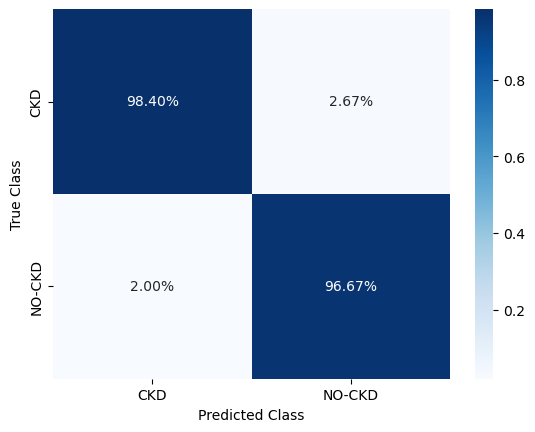

In [22]:
y_true = []
y_pred = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    xg_cl.fit(X_train, y_train)
    y_true.extend(y_test)
    y_pred.extend(xg_cl.predict(X_test))

cm = confusion_matrix(y_true, y_pred)

print("Confusion matrix:")
print(cm)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("Precision:", precision*100,"%")
print("F1 score:", f1*100,"%")
print("Kappa:", kappa*100,"%")
print("Specificity:", specificity*100,"%")
print("Sensitivity:", sensitivity*100,"%")


cm_normalized=cm/np.sum(cm,axis=1)
xl=['CKD', 'NO-CKD']
yl=['CKD','NO-CKD']
sns.heatmap(cm_normalized,cmap="Blues",fmt='.2%',annot=True,cbar_kws={"orientation":"vertical"},xticklabels=xl,yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")


In [23]:
model = LogisticRegression()
rfe = RFE(model,n_features_to_select=8)
fit = rfe.fit(X_train, y_train)

print("Features:",rfe.n_features_)
print("Feature ranking:", rfe.ranking_)
print("Best features:", X_train.columns[rfe.support_])
cv_scores=cross_val_score(rfe,X,y,cv=10)
print("accuracy:",cv_scores.mean())

Features: 8
Feature ranking: [15  9  7  1  1  2  5 11 14 10 16  1  8 12  1  6 17  1  1  1 13  1  3  4]
Best features: Index(['al', 'su', 'sc', 'hemo', 'rc', 'htn', 'dm', 'appet'], dtype='object')
accuracy: 0.9724999999999999


Confusion matrix:
 [[241   9]
 [  3 147]]
Precision: 94.23076923076923 %
F1 score: 96.07843137254902 %
Kappa: 93.65079365079364 %
Specificity: 96.39999999999999 %
Sensitivity: 98.0 %


Text(50.722222222222214, 0.5, 'True Class')

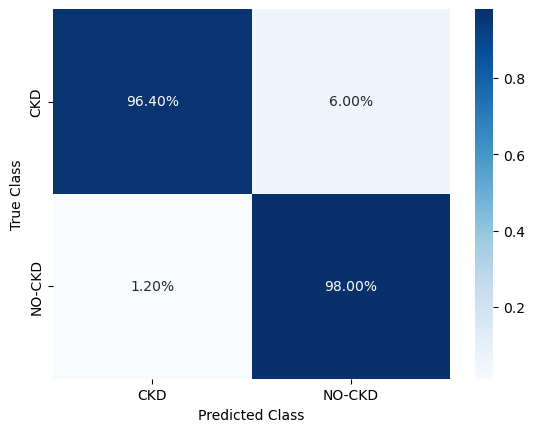

In [24]:
y_true = []
y_pred = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rfe.fit(X_train, y_train)
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    
    model.fit(X_train_rfe, y_train)
    
    y_pred_fold = model.predict(X_test_rfe)
    
    y_true.extend(y_test)
    y_pred.extend(y_pred_fold)
    
    
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("Precision:", precision*100,"%")
print("F1 score:", f1*100,"%")
print("Kappa:", kappa*100,"%")
print("Specificity:", specificity*100,"%")
print("Sensitivity:", sensitivity*100,"%")


cm_normalized=cm/np.sum(cm,axis=1)
xl=['CKD', 'NO-CKD']
yl=['CKD','NO-CKD']
sns.heatmap(cm_normalized,cmap="Blues",fmt='.2%',annot=True,cbar_kws={"orientation":"vertical"},xticklabels=xl,yticklabels=yl)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

In [68]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import ShuffleSplit

lda = LinearDiscriminantAnalysis()

cv = KFold(n_splits=10,shuffle = True, random_state=42)
# Evaluate the model using the cross-validation generator
scores = []
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

print("Average accuracy score:", sum(scores)/len(scores))
print("\n")

Average accuracy score: 0.9649999999999999




In [79]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold


# Set the number of folds for cross-validation
n_folds = 10

# Create the cross-validation object
kf = KFold(n_splits=n_folds, shuffle = True,random_state=42)

# Create an empty list to store the accuracy scores for each fold
scores = []

# Loop over the folds
for train_index, test_index in kf.split(X):
    # Split the data into training and test sets using .iloc indexing
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Perform PCA on the training set
    pca = PCA(n_components=24)
    X_train_pca = pca.fit_transform(X_train)
    
    # Use the same PCA transformation on the test set
    X_test_pca = pca.transform(X_test)
    
    # Train and evaluate a logistic regression model on the transformed data
    clf = LogisticRegression()
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    score = accuracy_score(y_test, y_pred)
    
    # Add the score for this fold to the list of scores
    scores.append(score)

# Calculate and print the mean and standard deviation of the scores
mean_score = np.mean(scores)
std_score = np.std(scores)
print("Accuracy: {:.2f}".format(mean_score))


Accuracy: 0.92
